<a href="https://colab.research.google.com/github/L4ncelot1024/Learn_Deep_Learning_Le_Wagon/blob/main/02_Regression_CHALLENGE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression

In a regression problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a classification problem, where we aim to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This notebook uses the classic [Auto MPG Dataset](https://archive.ics.uci.edu/ml/datasets/auto+mpg) and builds a model to predict the fuel efficiency of late-1970s and early 1980s automobiles. To do this, we'll provide the model with a description of many automobiles from that time period. This description includes attributes like: cylinders, displacement, horsepower, and weight.

In [ ]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [ ]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.0.0


## Data

### Downloading the data

In [ ]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

32768/30286 [================================] - 0s 2us/step


In [ ]:
# Importing the data with pandas
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Inspecting the data

In [ ]:
# TODO: check the distributions of the features 

<details>
<summary markdown='span'>View solution
</summary>

```python
stats = dataset.describe().transpose()
stats.head(10)
```

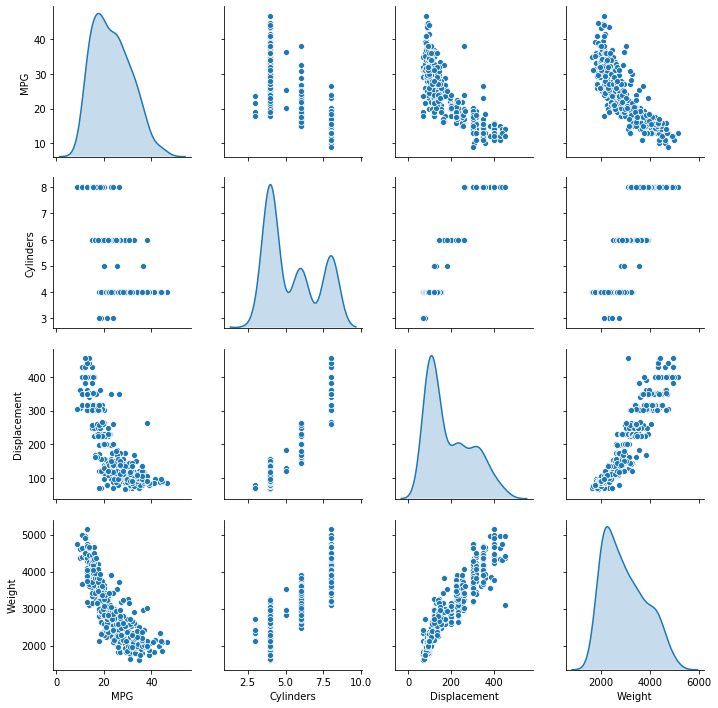

In [ ]:
# Here we plot the distributions of one column w.r.t another one in the extra
# diagonal cell and in diagonal cell the univariate distribution of the data
# for the variable in that column.
# you can check the documentation on seaborn 
# https://seaborn.pydata.org/generated/seaborn.pairplot.html
sns.pairplot(dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")
plt.show()

### Cleaning the data

In [ ]:
# TODO: check if there is Nan values

<details>
<summary markdown='span'>View solution
</summary>

```python
dataset.isna().sum()
```

In [ ]:
# TODO: since it's only a few rows we can just drop the Nan values
# (EXTRA: what else could we do?)

<details>
<summary markdown='span'>View solution
</summary>

```python
dataset = dataset.dropna()
print(dataset.shape)
```

From the documentation here are the columns:
1. mpg: continuous
2. cylinders: multi-valued discrete
3. displacement: continuous
4. horsepower: continuous
5. weight: continuous
6. acceleration: continuous
7. model year: multi-valued discrete
8. origin: multi-valued discrete
9. car name: string (unique for each instance)

In [ ]:
# TODO: convert discrete columns to one-hot if relevant
# (i.e. if there is a restricted number of categories and there is no value added with their numeric values, like ranking or others )

<details>
<summary markdown='span'>Hints
</summary>
Check the set of possible numerical values and if it's relevant to order them
</details>

<details>
<summary markdown='span'>Hints
</summary>
To convert to one-hot vartiable there is a pandas method very helpful. Check it <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html">here !</a>

</details>



<details>
<summary markdown='span'>View solution
</summary>

```python
print(dataset['Cylinders'].unique())
print(dataset['Model Year'].unique())
print(dataset['Origin'].unique())

# cylinders and Model Years can actually be compared with their numeric values so we keep it
dataset['Origin'] = dataset['Origin'].map(lambda x: {1: 'USA', 2: 'Europe', 3: 'Japan'}.get(x))
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()
```

### Splitting the dataset in train/test

In [ ]:
# TODO: split the dataset with 80% in test and 20% in train
# using https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html 
# (use the random_state=0 we all use the same)
# Extract then the labels and the feature separately



<details>
<summary markdown='span'>View solution
</summary>

```python
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

# .pop() removes the column from the dataframe and return it
train_labels = train_dataset.pop('MPG').values
test_labels = test_dataset.pop('MPG').values
```

### Normalize the data

In [ ]:
# TODO: build a function to normalize the dataset (ie 0-mean and 1-std) fropm the training statistics 

<details>
<summary markdown='span'>Hints
</summary>
You need to store the training mean/std so you can apply the same normalization to the test-data

</details>



<details>
<summary markdown='span'>View solution
</summary>

```python
train_stats = train_dataset.describe().transpose()

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset).values
normed_test_data = norm(test_dataset).values
```

## Modeling

### Architecture

In [ ]:
# TODO: build a Keras model with 2 hidden fully connected layers and one output layer

<details>
<summary markdown='span'>Hints
</summary>
Choose wisely about the size of your layers
</details>

<details>
<summary markdown='span'>Hints
</summary>
Don't forget to compile your models and think about which regression metrics you care about
</details>

<details>
<summary markdown='span'>Hints
</summary>
Wrapp the model building in a function so later on you just need to call this function
</details>


<details>
<summary markdown='span'>View solution
</summary>

```python
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model
  
model = build_model()

```

In [ ]:
# Inspect the model
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


### Training

In [ ]:
# TODO: train your models for 1000 epochs, don't forget to add your validation data in
# the training so you record the evolution of its loss as well

<details>
<summary markdown='span'>View solution
</summary>

```python
history = model.fit(
  normed_train_data, train_labels,
  epochs=1000, validation_split = 0.2)
```

In [ ]:
history_df = pd.DataFrame(history.history).reset_index().rename(columns={'index': 'epochs'})
history_df.tail()

,epochs,loss,mae,mse,val_loss,val_mae,val_mse
995,995,2.921094,1.116550,2.921094,8.677700,2.264218,8.677700
996,996,2.701735,1.028421,2.701735,9.089249,2.297744,9.089249
997,997,2.924568,1.043489,2.924568,8.222639,2.210282,8.222639
998,998,2.593975,0.990671,2.593975,8.428648,2.235385,8.428648
999,999,2.704547,1.015664,2.704548,9.103234,2.281416,9.103234


In [ ]:
# TODO: plot the evolution of the metrics

<details>
<summary markdown='span'>View solution
</summary>

```python
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

for i, metric in enumerate(['loss', 'mae', 'mse']):
  ax = axes[i]
  history_df.plot('epochs', f'{metric}', color='g', label='train', ax=ax)
  history_df.plot('epochs', f'val_{metric}', color='r', label='test', ax=ax)
  ax.set_ylabel(metric)
  ax.set_ylim([0, 20])
plt.show()
```

Make some observations from your plots:
- Is the metric evolving similarly in your train and in your test set?
- Are you observing a flaw in your model?

In [ ]:
# TODO: evaluate the model on your test data

<details>
<summary markdown='span'>View solution
</summary>

```python
 loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
```

### Early-stopping

To prevent from overfitting you can stop the training once the performances of your model on heldout data (= data not seen at training) starts to decrease. Then you record the number of epoch at which you should stop.

Keras implements this as a callbacks, it's a method which is called during training and can impact the training loops.

Check [here](https://keras.io/callbacks/#earlystopping) the documentation on how to use it.

In [ ]:
# TODO: Add early stopping in your training

<details>
<summary markdown='span'>View solution
</summary>

```python
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=1000,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop])
```

In [ ]:
# TODO: plots the evolution of the metrics during training with the history

<details>
<summary markdown='span'>View solution
</summary>

```python
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

for i, metric in enumerate(['loss', 'mae', 'mse']):
  ax = axes[i]
  history_df.plot('epochs', f'{metric}', color='g', label='train', ax=ax)
  history_df.plot('epochs', f'val_{metric}', color='r', label='test', ax=ax)
  ax.set_ylabel(metric)
  ax.set_ylim([0, 20])
plt.show()

history_df = pd.DataFrame(history.history).reset_index().rename(columns={'index': 'epochs'})
history_df.tail()
```

In [ ]:
# TODO: Evaluate the results on your test data

<details>
<summary markdown='span'>View solution
</summary>

```python
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
```

You've found out when to stop training in order not to overfit to your train data, but you fitted your model only on 80% of the training data. Don't forget that the data is your most important source of information so you should use the maximum of it.

How to do this? You can get the optimized number of epoch to fit your model and then use it when fitting your model on the whole train set !

In [ ]:
# TODO: extract the number of epoch at which the early stopping triggered

<details>
<summary markdown='span'>Hints
</summary>
This number is stored in the attribute `.stopped_epoch` of your early_stop callback
</details>

<details>
<summary markdown='span'>Hints
</summary>
Retrieve from it the patience since you want only the number of steps needed to reach the best performances on your validation set
</details>

<details>
<summary markdown='span'>View solution
</summary>

```python
num_epoch_optimized = es.stopped_epoch - patience
print(num_epoch_optimized)
```

In [ ]:
# TODO: Fit your model on all your train data this time with the optimized
# number of epochs 

<details>
<summary markdown='span'>View solution
</summary>

```python
model = build_model()
 
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)
 
history = model.fit(normed_train_data, train_labels, epochs=num_epoch_optimized, verbose=2)
```

In [ ]:
# TODO: Evaluate the results on your test data


<details>
<summary markdown='span'>View solution
</summary>

```python
# Evaluate the results on your test data
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
````

### Predict

In [ ]:
# TODO: predict the values of your test data and plot the true values VS the predicted values

<details>
<summary markdown='span'>View solution
</summary>

```python
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)

plt.show()
```